# Finding Similar Items. LSH. 

This laboratory work is about python implementation of locality sensitive hashing. 

We use 4 articles from US CNN, and a 5th that is partial concatenation of 3 of those, to artificially produce similarity scores. 

Content of the lab material as follows:
1. Shingle function 
2. Jaccard similarity between all pairs 
3. MinHash class 
  - key-value pairs for the shingles 
  - applying 'universal hashing' to perform minhashing on a shingle set 
4. Evaluating MinHashing effectiveness by computing scores of all pairs 
5. LSH class to find candidate pairs, i.e. use a banded signature matrix to find all pairs whose similarity is likely above a threshold 
6. Make this efficient, by using hash table for band, column ids, allowing O(n) comparison

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 52.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=956faf77cbedc615ffa696760a34a67c0ab0f25ccb095281036c8f398bd5f576
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import os
import time
import itertools
import collections
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

## Document Similarity

### Shingling

In [ ]:
HOME = os.getcwd()
TARGET = os.path.join(HOME, 'docs/')

documents = []
for article in os.listdir(TARGET):
    if article == 'stopwords':
        continue
    path = os.path.join(TARGET, article)
    with open(path, 'r') as file:
        documents.append(file.read())
        
stopwords = []
with open(os.path.join(TARGET, 'stopwords'), 'r') as file:
    for line in file:
        stopwords.append(line.strip())
        
for i, doc in enumerate(documents):
    doc = doc.strip().replace('\n', ' ').lower()
    for word in stopwords:
        doc = doc.replace(' '+word+' ', ' ')
    documents[i] = doc

print(f"Average char-length: {np.mean(np.array([len(x) for x in documents]))}")
print(f"Min char-length: {min(len(x) for x in documents)}")
print(f"Max char-length: {max(len(x) for x in documents)}")

Average char-length: 3651.6
Min char-length: 2412
Max char-length: 5873


In [ ]:
for i in documents:
  print(len(i), ':', i)

5873 : ew quarantine hobbies unearthed new passions, bringing literal silver lining. year, backyard archaeologists united kingdom recorded discoveries 47,000 objects, british museum announced week. regular people found vast majority historical artifacts traversing countryside metal detectors, adding updating records museum's portable antiquities scheme. british museum said program also saw uptick people updating digital records antiquities country full lockdown march 22 may 13. database contains records 1.5 million objects discovered since 1998 general public rather professional archaeologists. "it brilliant see scheme growing strength strength lockdown thanks garden discoveries digital reporting," said uk culture minister caroline dinenage, news release. list garden treasures dug year includes 13th century medieval seal, bearing latin inscription reading "david, god's messenger, bishop st. andrews." major coin hoard, held 63 gold coins one silver coin featuring monarchs edward iv henr

In [ ]:
def getShingles(str1, K=5):
    d1 = set()
    for i in range(len(str1)-K):
        d1.add(str1[i:i+K])
    print(f"Found {len(d1)} unique shingles, out of {len(str1)} possible.")
    return d1

In [ ]:
doc_shingles = [getShingles(s, 5) for s in documents]

Found 3953 unique shingles, out of 5873 possible.
Found 2782 unique shingles, out of 3673 possible.
Found 1918 unique shingles, out of 2412 possible.
Found 2091 unique shingles, out of 3291 possible.
Found 2060 unique shingles, out of 3009 possible.


### Jaccard Similarity

In [ ]:
def jaccardSim(d1,d2):
    return len(d1.intersection(d2))/len(d1.union(d2))

In [ ]:
pairs = itertools.combinations(documents, 2)
pair_labels = []
pair_sims = []
for x1, x2 in itertools.combinations(zip(range(len(doc_shingles)),doc_shingles), 2):
    pair_labels.append((x1[0],x2[0]))
    pair_sims.append(jaccardSim(x1[1],x2[1]))
    
print(f"**~~~~~~ True similarity scores ~~~~~~**")
print("Pair\tScore")
print("-"*14)
for pair, score in zip(pair_labels, pair_sims):
    print(f"{pair}\t{score:.3f}")

**~~~~~~ True similarity scores ~~~~~~**
Pair	Score
--------------
(0, 1)	0.083
(0, 2)	0.400
(0, 3)	0.294
(0, 4)	0.336
(1, 2)	0.052
(1, 3)	0.081
(1, 4)	0.069
(2, 3)	0.051
(2, 4)	0.050
(3, 4)	0.093


In [ ]:
fullset = set.union(*doc_shingles)
shingle_dict = dict(zip(list(fullset),range(len(fullset))))
print(f"There are {len(shingle_dict)} shingles")

There are 7534 shingles


### MinHash class

In [ ]:
class HashManager():
    def __init__(self, shingle_dict):
        self.shingle_dict = shingle_dict
        self.N = len(shingle_dict)
        self.params = None
        
    def _initParams(self, n_sig):
        self.params = np.random.randint(self.N, size=[n_sig,2])
    
    def _permuteRow(self, row):
        return (self.params@np.array([1,row]))%self.N
    
    def __call__(self, docs, n_sig, init=True):
        # Initialize if we change signature matrix length
        # or if we request to re-initialize
        if self.params is None or len(self.params) != n_sig or init:
            self._initParams(n_sig)
            
        #initialize signature matrix
        sig = np.full((n_sig, len(docs)), np.inf)
        
        # each doc in docs is assumed to be an iterable object
        for j, doc in enumerate(docs):
            for shingle in doc:
                orig_row = shingle_dict[shingle]
                curr_col = self._permuteRow(orig_row)
                sig[:,j] = np.minimum(sig[:,j],curr_col)
        return sig.astype(int)
    
# run some tests:
try:
    print("Initialization test: ", end="")
    hm = HashManager(shingle_dict)
    print("passed")

    print("Set parameters to right size: ", end="")
    hm._initParams(n_sig=4)
    assert(hm.params.shape == (4,2))
    print("passed")

    print("Permuting a row integer returns array: ", end="")
    curr_col = hm._permuteRow(3)
    assert(curr_col.shape == (4,))
    print("passed")

    print("Compute minhashed signature matrix: ", end="")
    hm(doc_shingles, 4)
    print("passed")
except Exception as e:
    print("failure")
    print(e.args)

Initialization test: passed
Set parameters to right size: passed
Permuting a row integer returns array: passed
Compute minhashed signature matrix: passed


In [ ]:
hm = HashManager(shingle_dict)

### Using MinHashing to compute similarity scores

In [ ]:
def trueSimScores(doc_shingles):
    pair_labels = []
    pair_sims = []
    idxs = range(len(doc_shingles))
    for x1, x2 in itertools.combinations(zip(idxs,doc_shingles), 2):
        pair_labels.append((x1[0], x2[0]))
        pair_sims.append(jaccardSim(x1[1], x2[1]))
    return dict(zip(pair_labels, pair_sims))
    
def sigSimScores(sig_mat):
    cols = sig_mat.T
    idxs = range(sig_mat.shape[1])
    
    pair_labels = []
    pair_sims = []
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs, cols),2):
        pair_labels.append((i,j))
        pair_sims.append(np.mean(col1==col2))
    
    return dict(zip(pair_labels, pair_sims))

def printScoreComparison(true_dict, approx_dict):
    print(f"**~~~~~~ Similarity score comparison ~~~~~~**")
    print("Pair\t\tApprox\t\tTrue\t\t%Error")
    for pair, true_value in true_dict.items():
        approx_value = approx_dict[pair]
        err = 100*abs(true_value-approx_value)/true_value
        print(f"{pair}\t\t{approx_value:.3f}\t\t{true_value:.3f}\t\t{err:.2f}")

def candidatePairs(score_dict, threshold):
    return set(pair for pair, scr in score_dict.items() if scr>=threshold)

def accMatrix(true_dict, approx_dict, threshold):
    true_pairs = candidatePairs(true_dict, threshold)
    approx_pairs = candidatePairs(approx_dict, threshold)
    false_negatives = len(true_pairs - approx_pairs)
    false_positives = len(approx_pairs - true_pairs)
    print(f"False negatives: {false_negatives}")
    print(f"Potential false positives: {false_positives}")

In [ ]:
sig_mat = hm(doc_shingles, 10)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
printScoreComparison(true_score_dict, approx_score_dict)

print("True pairs:",candidatePairs(true_score_dict, 0.25))
print("Candidate pairs:",candidatePairs(approx_score_dict, 0.25))
accMatrix(true_score_dict, approx_score_dict, 0.4)

**~~~~~~ Similarity score comparison ~~~~~~**
Pair		Approx		True		%Error
(0, 1)		0.200		0.083		141.05
(0, 2)		0.500		0.400		24.94
(0, 3)		0.400		0.294		35.83
(0, 4)		0.300		0.336		10.77
(1, 2)		0.200		0.052		286.93
(1, 3)		0.300		0.081		270.52
(1, 4)		0.100		0.069		45.19
(2, 3)		0.300		0.051		483.62
(2, 4)		0.000		0.050		100.00
(3, 4)		0.300		0.093		221.78
True pairs: {(0, 3), (0, 2), (0, 4)}
Candidate pairs: {(1, 3), (2, 3), (0, 4), (0, 3), (3, 4), (0, 2)}
False negatives: 0
Potential false positives: 1


In [ ]:
sig_mat = hm(doc_shingles, 10)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
printScoreComparison(true_score_dict, approx_score_dict)

print("True pairs:",candidatePairs(true_score_dict, 0.25))
print("Candidate pairs:",candidatePairs(approx_score_dict, 0.25))
accMatrix(true_score_dict, approx_score_dict, 0.4)

**~~~~~~ Similarity score comparison ~~~~~~**
Pair		Approx		True		%Error
(0, 1)		0.200		0.083		141.05
(0, 2)		0.600		0.400		49.93
(0, 3)		0.600		0.294		103.74
(0, 4)		0.200		0.336		40.52
(1, 2)		0.200		0.052		286.93
(1, 3)		0.200		0.081		147.01
(1, 4)		0.300		0.069		335.58
(2, 3)		0.300		0.051		483.62
(2, 4)		0.300		0.050		501.43
(3, 4)		0.300		0.093		221.78
True pairs: {(0, 3), (0, 2), (0, 4)}
Candidate pairs: {(1, 4), (2, 3), (2, 4), (0, 3), (3, 4), (0, 2)}
False negatives: 0
Potential false positives: 1


### Locality Sensitive Hashing , band-structure theory, how to choose band size

#### Effects of changing b, r at fixed n

Now implement Locality-sensitive hashing. We use a band structure on the signature matrix. If the matrix has `n` rows, then we divide it into `b` bands each of width `r`, such that 

`n = b * r`

Let `p` be the true similarity score (match percent) between a pair. The probability of matching every integer in a band is 

`prob. one band doesn't match = 1 - p^r`

Now the probability that NONE of the `b` bands match is given by

`prob. no bands match = (1 - p^r)^b` 

Therefore, the probability that at least one band matches, is

`P(X > 0) = 1 - (1 - p^r)^b` 

Now, we want this to be our criteria for a candidate pair. That is, two signatures columns are a candidate pair if `P >= 1/2` . We will see in the plot below, that as the signature matrix increases, we can tune `r` and `b` to approximately be a step function around the true value of `p`. The goal is to find as few candidate pairs as possible, while also making sure we find them all.

Draw a vertical line at the true p value The area UNDER the curve `P(x < p)` represents the rate of potential false positives

the area ABOVE the curve `P(x >= p)` represents the rate of false negatives

For various values of `r`, `b`, we plot the result below

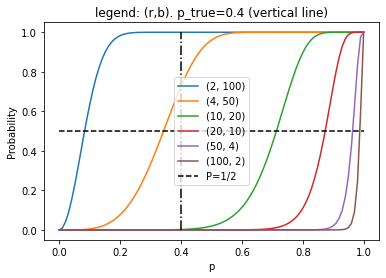

In [ ]:
import matplotlib.pyplot as plt
n = 200
ops = [(2,100),(4,50),(10,20),(20,10),(50,4),(100,2)]
yval = lambda p,r,b: 1-(1-p**r)**b
pts = np.linspace(0,1,100)
yval(pts,.2,.2)
for op in ops:
    plt.plot(pts, yval(pts,op[0],op[1]), label=op)
plt.plot(pts,0*pts+0.5,'k--', label="P=1/2")
plt.plot([0.4,0.4],[0,1], 'k-.')
plt.legend()
plt.xlabel('p')
plt.ylabel('Probability')
plt.title("legend: (r,b). p_true=0.4 (vertical line)")
plt.show()

#### Effects of changing n while adjusting b,r to keep P=1/2 argument constant 

Now let's solve for the optimal values r,b. 

We suppose that we fix `n, r, b`. Given these, we determine at which approximate point `p` is the crossover. We should find `p = p(b,r)`. Afterwards, we can then approximately solve for `r, b` to be a desired `p`. 

We begin with for `P = 1/2`. 

$$1/2 = 1 - (1 - p^r)^b$$

$$1 - p^r = 2^{-1/b}$$

$$p = (1 - 2^{-1/b})^{1/r} = (1 - e^{-(1/b)ln2})^{1/r} ≈ (1/b)^{1/r} * const$$ 

Finally, if we fix `r` and `p`, we can find the required bands to be about $$b \approx 1/p^r $$

Takeaways: 

increasing `r ->`
- moves the curve right.
- more the false negatives
- means lower chance to match

increasing `b ->`
- moves the curve left.
- more false positives
- means higher chance to match

increasing `n ->`
- the curve approaches a step function.
- fewer false anythings
- always good!

Now watch what happens as we pick the optimal r,b and then increase n.

We will try to keep p centered around `p = 0.5`.

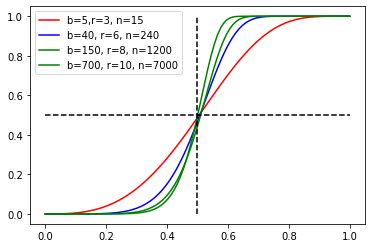

In [ ]:
x = np.linspace(0,1,100)

b,r = 5, 3
y = 1-(1-x**r)**b
plt.plot(x,y,'r-',label=f"b={b},r={r}, n={b*r}")

b,r = 40, 6
y = 1-(1-x**r)**b
plt.plot(x,y,'b-',label=f"b={b}, r={r}, n={b*r}")

b,r = 150, 8
y = 1-(1-x**r)**b
plt.plot(x,y,'g-',label=f"b={b}, r={r}, n={b*r}")

b,r = 700, 10
y = 1-(1-x**r)**b
plt.plot(x,y,'g-',label=f"b={b}, r={r}, n={b*r}")


plt.plot(x,0*x+0.5,'k--')
plt.plot([0.5,0.5],[0,1],'k--')
plt.legend()
plt.show()

Now, we use all of the above to try to optimize our Localitly Sensitive Hash function from before. 

Let's say we want a threshold of `p = 0.3`. We can calculate $b ≈ p^{-r}$ for the number of bands.

For the first 6 values of band size we determine we should keep

$ r = 1 \to b = 3, n = 3$

$ r = 2 \to b = 11, n = 22$

$ r = 3 \to b = 37, n = 111$

$ r = 4 \to b = 123, n = 492$

$ r = 5 \to b = 412, n = 2060$

Let's try the intermediate choice, and use round numbers `n = 120, b = 40, r = 3`

Let's see how good our results are using the previous defined functions. We first need to construct the banded similarity measure to be used on the signature matrix. Put this into a function

### Brute force banded candidate pair function, for checking hash method later

In [ ]:
def bandedCandidatePair(col1, col2, b, r):
    """Returns a boolean if the two columns are a candidate pair
    inputs must obey n=len(col1)=len(col2)=b*r"""
    n = len(col1)
    assert(n==b*r)
    assert(n==len(col2))
    truth_array = (col1==col2)
    return any(all(band) for band in np.array_split(truth_array,b))

def bandedCandidatePairs(sig_mat, b, r):
    d = sig_mat.shape[1]
    idxs = range(d)
    cols = [sig_mat[:,i] for i in range(d)]
    pairs = set()
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs,cols),2):
        if bandedCandidatePair(col1,col2,b,r):
            pairs.add((i,j))
    return pairs

# set p = 0.3 arbitrarily
p = 0.3
n = 120
b = 30
r = 4

# see how many candidate pairs we got right!
sig_mat = hm(doc_shingles, n)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
print("True pairs:",candidatePairs(true_score_dict, p))
print("LSH pairs:",bandedCandidatePairs(sig_mat, b, r))
print("Vanilla MinHash pairs:",candidatePairs(approx_score_dict, p))
# accMatrix(true_score_dict, approx_score_dict, 0.4)

# sig_mat = hm(doc_shingles, n)
# true_score_dict = trueSimScores(doc_shingles)
printScoreComparison(true_score_dict, approx_score_dict)

True pairs: {(0, 2), (0, 4)}
LSH pairs: {(0, 2)}
Vanilla MinHash pairs: {(0, 3), (0, 2), (0, 4)}
**~~~~~~ Similarity score comparison ~~~~~~**
Pair		Approx		True		%Error
(0, 1)		0.275		0.083		231.44
(0, 2)		0.483		0.400		20.78
(0, 3)		0.425		0.294		44.31
(0, 4)		0.342		0.336		1.62
(1, 2)		0.175		0.052		238.56
(1, 3)		0.200		0.081		147.01
(1, 4)		0.125		0.069		81.49
(2, 3)		0.167		0.051		224.23
(2, 4)		0.142		0.050		184.01
(3, 4)		0.167		0.093		78.77


### Finally, we perform the fast candidate pair search, using a hash table of band and column id's 

Lastly, we will improve upon the whole efficiency by performing the comparisons of banded pairs in $O(n)$ time as opposed to $O(n^2)$

For each band of a column, we place a copy of the column index into a hash table, with key the row values.

For example, let col=[4,2,5,6]. This might band to say [(4,2),(5,6)], and we ould enter into a dictionary d={(4,2):[col,...], (5,6):[col,...], ...}

In [ ]:
def fastCandidatePairs(sig_mat, b, r):
    n, d = sig_mat.shape
    assert(n==b*r)
    hashbuckets = collections.defaultdict(set)
    bands = np.array_split(sig_mat, b, axis=0)
    for i,band in enumerate(bands):
        for j in range(d):
            # The last value must be made a string, to prevent accidental
            # key collisions of r+1 integers when we really only want
            # keys of r integers plus a band index
            band_id = tuple(list(band[:,j])+[str(i)])
            hashbuckets[band_id].add(j)
    candidate_pairs = set()
    for bucket in hashbuckets.values():
        if len(bucket) > 1:
            for pair in itertools.combinations(bucket, 2):
                candidate_pairs.add(pair)
    return candidate_pairs


# to make sure it works, 
# compare with the brute force method on a few trials

# set p = 0.3 arbitrarily
p = 0.3
n = 120
b = 30
r = 4

# see how many candidate pairs we got right!
sig_mat = hm(doc_shingles, n)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
print('True pairs:\t', candidatePairs(true_score_dict, p))
print("True LSH pairs:\t", bandedCandidatePairs(sig_mat, b, r))
print("Fast LSH pairs:\t", fastCandidatePairs(sig_mat, b, r))
print("MinHash pairs:\t", candidatePairs(approx_score_dict, p))

True pairs:	 {(0, 2), (0, 4)}
True LSH pairs:	 {(0, 2)}
Fast LSH pairs:	 {(0, 2)}
MinHash pairs:	 {(0, 3), (0, 2), (0, 4)}


## LSH on vectors

Also, you can work with the already implemented PySpark's LSH method. There is [PySpark documentation](https://spark.apache.org/docs/2.2.3/ml-features.html#locality-sensitive-hashing). 